In [124]:
import block
import importlib
import dataloader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import cv2
import numpy as np
import gc
import loss
import train
import test
import utils

In [125]:
importlib.reload(dataloader)
importlib.reload(block)
importlib.reload(loss)
importlib.reload(train)
importlib.reload(test)
importlib.reload(utils)

<module 'utils' from 'd:\\Documents\\machinelearning\\SIR\\ShallowFE\\utils.py'>

In [126]:
from dataloader import ImageDataset, ImageLoader

dataset = ImageDataset("../data/")
loader = ImageLoader(dataset, batch_size=1)

In [127]:
test_loader, train_loader = ImageLoader(dataset[2000:], batch_size=4), ImageLoader(
    dataset[:2000], batch_size=3
)

**Test Image**

In [128]:
img = loader.dataset[2049]

In [129]:
sizes = [16, 32, 64, 128]

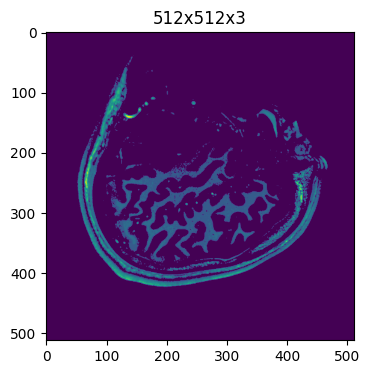

In [130]:
plt.figure(figsize=(6, 4))
plt.title("512x512x3")
plt.imshow(img[0][0])
plt.show()

In [131]:
prev_params = None
for size in sizes:
    fe = block.ShallowFE(img.shape[1], size)
    num_params = sum(p.numel() for p in fe.parameters())
    if prev_params is not None:
        increase_percent = ((num_params - prev_params) / prev_params) * 100
        print(
            f"Number of parameters for output size {size}: {num_params:,} (+{increase_percent:.2f}%)"
        )
    else:
        print(f"Number of parameters for output size {size}: {num_params:,}")
    prev_params = num_params

del fe
gc.collect()
torch.cuda.empty_cache()

Number of parameters for output size 16: 69,639
Number of parameters for output size 32: 265,327 (+281.00%)
Number of parameters for output size 64: 1,036,095 (+290.50%)
Number of parameters for output size 128: 4,095,199 (+295.25%)


In [132]:
TRAIN, TEST, EVAL = True, False, False
    
if TRAIN:
    for size in sizes:
        fe = block.ShallowFE(img.shape[1], size)
        optimizer = optim.Adam(fe.parameters(), lr=0.00001)
        train.train(fe, train_loader, loss.VGGPerceptualLoss(), optimizer, size, 5, iter=100)
        gc.collect()
        torch.cuda.empty_cache()

Training is True
Epoch:1


0it [00:00, ?it/s]c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\Tawan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
134it [00:56,  2.35it/s]


KeyboardInterrupt: 

In [ ]:
if TEST:
    for size in [64, 256]:
        plt.figure(figsize=(32, 6))
        plt.subplot(1, 7, 1)
        plt.title(f"{size}: Original")
        plt.imshow(img[0][0])
        for epoch in range(3, 9):
            plt.subplot(1, 7, epoch - 1)
            plt.title(f"{size}: {"Epoch" + str(epoch - 3) if epoch < 8 else 'Untrained'}")
            fe = block.ShallowFE(img.shape[1], size)
            if epoch >= 0 and epoch < 8:
                fe.load_state_dict(torch.load(f"./models/model({size})_{epoch - 3}.pth"))
            fe.eval()
            #test.test(fe, test_loader)
            plt.imshow(fe(img)[0][0].detach().cpu().numpy())
            torch.cuda.empty_cache()
            gc.collect()
        plt.show()

In [ ]:
if EVAL:
    for res in range(2, 5):
        transform = transforms.Compose([utils.DecreaseResolution(3, depth = res)])
        copied = img.clone()
        copied[0] = transform(copied)
        for size in sizes:
            plt.figure(figsize=(32, 6))
            plt.title(f"Degraded scale {res}x")
            plt.subplot(1, 7, 1)
            plt.title(f"{size}: Original")
            plt.imshow(copied[0][0])
            for epoch in range(3, 9):
                plt.subplot(1, 7, epoch - 1)
                plt.title(f"{size}: {"Epoch" + str(epoch - 3) if epoch < 8 else 'Untrained'}")
                fe = block.ShallowFE(copied.shape[1], size)
                
                if epoch >= 0 and epoch < 8:
                    fe.load_state_dict(torch.load(f"./models/model({size})_{epoch - 3}.pth"))
                fe.eval()
 
                #test.test(fe, test_loader)
                
                out = copied.clone()
 
                out = fe(out)

                plt.imshow(out[0][0].detach().cpu().numpy())

                torch.cuda.empty_cache()
                gc.collect()
            plt.show()